In [1]:
import tables, glob, os, time, sys
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d, Axes3D
import matplotlib.colors as colors
from scipy.stats import norm

from stl import mesh
from mpl_toolkits import mplot3d
import scipy.constants as con

In [2]:
def ReadFile(Keys, File): 
    if not os.path.isfile(File):
        print('no')
        return
    else: 
        Data = {}
        try:
            with tables.open_file(File, mode="r") as f: 
                for Key in Keys:    
                    data = f.root._f_get_child(Key)._f_get_child(Key).read()
                    if data is None:
                        print(data)
                    Data[Key] = data
            if Data is None: 
                print(Data)
            return(Data)
        except:
            return 

In [3]:
def GetPhotonFlags(Flags):
    PhotonFlags = {}
    PhotonFlags['NO_HIT'] = (Flags & (0x1 << 0)).astype(bool)   
    PhotonFlags['BULK_ABSORB'] = (Flags & (0x1 << 1)).astype(bool)   
    PhotonFlags['SURFACE_DETECT'] = (Flags & (0x1 << 2)).astype(bool)   
    PhotonFlags['SURFACE_ABSORB'] = (Flags & (0x1 << 3)).astype(bool)   
    PhotonFlags['RAYLEIGH_SCATTER'] = (Flags & (0x1 << 4)).astype(bool)   
    PhotonFlags['REFLECT_DIFFUSE'] = (Flags & (0x1 << 5)).astype(bool)   
    PhotonFlags['REFLECT_SPECULAR'] = (Flags & (0x1 << 6)).astype(bool)    
    PhotonFlags['SURFACE_REEMIT'] = (Flags & (0x1 << 7)).astype(bool)    
    PhotonFlags['SURFACE_TRANSMIT'] = (Flags & (0x1 << 8)).astype(bool)    
    PhotonFlags['BULK_REEMIT'] = (Flags & (0x1 << 9)).astype(bool)   
    PhotonFlags['MATERIAL_REFL'] = (Flags & (0x1 << 10)).astype(bool)  
    PhotonFlags['NAN_ABORT'] = (Flags & (0x1 << 31)).astype(bool)  
    return PhotonFlags

In [18]:
allKeys = ['NumDetected', 'ChannelCharges', 'ChannelIDs', 'NumHitChannels', 
                  'IncidentAngles', 'Flags', 'LastHitTriangle', 'FinalPosition', 'InitialPosition', 'DetectedPos', 
                  'PhotonWavelength',  'DetectorHit', 'PhotonTime']


#10 muons, 70 PMTs, QE on - trying to get channel hit time
# File1 = "h5_files/chroma_nEXO_OD_OD_70PMT_QE_210719_143945_r1707.h5"
# #same but with photonTime variables
File1 = "h5_files/chroma_nEXO_OD_OD_70PMT_QE_210719_163329_r1658.h5"

# #first try with muon time passed to photon event, 1 muon straight through center, WT, no QE
# File1 = "h5_files/chroma_nEXO_OD_OD_fullAbs_WT_TEST_210722_153136_r6574.h5"

# #same thing, with matching to just muon-photon timing csv file
# File1 = "h5_files/chroma_nEXO_OD_OD_fullAbs_WT_TEST_210723_110426_r7662.h5"
# timeFile = np.genfromtxt("TimeOutput.csv", delimiter=',')
# print(timeFile[0])

Data1 = ReadFile(allKeys, File1)

In [101]:
print(Data1.keys())

# for var in Data1.keys():
#     print(var, "- number of entries:", len(Data1[var]))
#     print("     ", Data1[var], '\n')
print(Data1['NumDetected'])

dict_keys(['NumDetected', 'ChannelCharges', 'ChannelIDs', 'NumHitChannels', 'IncidentAngles', 'Flags', 'LastHitTriangle', 'FinalPosition', 'InitialPosition', 'DetectedPos', 'PhotonWavelength', 'DetectorHit', 'PhotonTime'])
[ 1606 12042  6314  2232  7939  1279  2777  1764 10522  4741]


## Looking at photon paths

In [13]:
I_pos = Data1['InitialPosition'].T
f_pos = Data1['FinalPosition'].T  
d_pos = Data1['DetectedPos'].T  

In [ ]:
fig = plt.figure(figsize=(7,7))
axes = mplot3d.Axes3D(fig)

axes.scatter3D(I_pos[0], I_pos[1], I_pos[2], 'blue', label='intial', s=0.9)
# axes.scatter3D(f_pos[0], f_pos[1], f_pos[2], 'red', alpha=0.1, s=0.6, label='final')

axes.scatter3D(d_pos[0], d_pos[1], d_pos[2], 'orange', alpha=0.1, s=0.6, label='detected')

# axes.set_xlim3d(-6000, 6000)
# axes.set_ylim3d(-6000, 6000)
# axes.set_zlim3d(-7800, +6730)

axes.set_xlabel("X [mm]")
axes.set_ylabel("Y [mm]")
axes.set_zlabel("Z [mm]")
axes.xaxis.labelpad=20
axes.yaxis.labelpad=15
# axes.zaxis.labelpad=15

lgnd = axes.legend()

#change the marker size manually for both lines
for L in lgnd.legendHandles:
    L._sizes = [30]
    L.set_alpha(1)
    
#change angle of view - (elevation, azimuth) angles in degrees
# ‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
axes.view_init(0, 70)

# 0, 90 - XZ plane; 90, 90 - top view

plt.show()

## Looking at timing total

In [15]:
def plotLightMapTime(top, side, bottom, title="Light Map", s=30):

    fig, axes = plt.subplots(3, 1, figsize=(6,14))

    Colmap=plt.get_cmap('viridis')
    
    fig.suptitle(title)
    #### top of watertank #####

    plot1 = axes[0].scatter(top[1], top[0], c=top[2], cmap=Colmap, s=s)
    
    axes[0].set_ylabel("X [mm]")
    axes[0].set_xlabel("Y [mm]")
    # axes[0].tick_params(labelbottom=False,labeltop=True)
    axes[0].xaxis.set_ticks_position('top') 
    axes[0].xaxis.set_label_position('top')
    axes[0].set_title('Top', x =1.1, y=0.5,)

    #### wall of watertank #####
    #Azimuthal position [rad]

    plot2 = axes[1].scatter(side[0], side[1], c=side[2], cmap=Colmap, s=s)
        
    axes[1].set_xlabel("Azimuthal position [rad]")
    axes[1].set_ylabel("Z [mm]")
    axes[1].set_title('Wall', x =1.1, y=0.5,)
    axes[1].set_xticks(np.arange(-np.pi, np.pi+0.1, np.pi/4))
    labels = [r'-$\pi$', r'$-3\pi/4$', r'$-\pi/2$', r'-$\pi/4$', '$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$',]
    axes[1].set_xticklabels(labels)


    #### bottom of watertank #####
    plot3 = axes[2].scatter(bottom[1], bottom[0], c=bottom[2], cmap=Colmap, s=s)
        
    axes[2].set_ylabel("X [mm]")
    axes[2].set_xlabel("Y [mm]")
    axes[2].set_title('Bottom', x =1.1, y=0.5,)

    # Find the min and max of all colors for use in setting the color scale.
    images = [plot1, plot2, plot3]
    
    vmin = min(image.get_array().min() for image in images)
    vmax = max(image.get_array().max() for image in images)
    
    norm = colors.Normalize(vmin=vmin, vmax=vmax) 
    for im in images:
        im.set_norm(norm)


    cbar = fig.colorbar(images[0], ax=axes, shrink=0.95, pad=.14)
    # cbar.set_ticks(np.arange(0, 1.1, 0.5))
    cbar.set_label('Time from Muon entering WT [ns]')
    plt.show()

In [20]:
detectedPos = Data1['DetectedPos']
PhotonTiming = Data1['PhotonTime']

#approximate values to only plot photons with a dimension larger than these for each of the three graphss
topHeight = 5000
bottomHeight = -5000
radius = 6000

#get hits on surfaces
top_hits = []
bottom_hits = []
side_hits = []
all_sides_hits = []
skipped_hits = 0
timeMin = 35 #ns
timeMax = 40 #ns

# PhotonFlags = [GetPhotonFlags(x) for x in Data1['Flags']]
PhotonFlags_flip = GetPhotonFlags(Data1['Flags']) # it's so much faster this way
DetectedBool = PhotonFlags_flip['SURFACE_DETECT']

d = 0

for i, flagtag in enumerate(Data1['Flags']):
#     print(GetPhotonFlags(flagtag))
    if DetectedBool[i] and timeMax > PhotonTiming[i] >= timeMin: #only save those that are detected
        x,y,z = detectedPos[d]
        R = np.sqrt(x*x + y*y)
        Az = np.arctan2(y, x)
        
#         print([x,y,z], [R, Az, z])
#         print(z)
        
        #save photons that stopped only near the edge of the WT - to be improved later
        if z >= topHeight:
#             print(z)
            top_hits.append([x,y,PhotonTiming[i]])
            all_sides_hits.append([x,y,z])
        elif z <= bottomHeight:
            bottom_hits.append([x,y,PhotonTiming[i]])
            all_sides_hits.append([x,y,z])
        elif R > radius:
            side_hits.append([Az, z, PhotonTiming[i]])
            all_sides_hits.append([x,y,z])
        
        d +=1
            
    else:
        skipped_hits +=1
            
top_hits = np.array(top_hits).T
bottom_hits = np.array(bottom_hits).T
side_hits = np.array(side_hits).T
all_sides_hits = np.array(all_sides_hits).T

In [21]:
# print(len(all_sides_hits[0]))

print("Total of %i photons detected." % len(all_sides_hits[0]))
print(len(top_hits[0]))

Total of 445 photons detected.
105


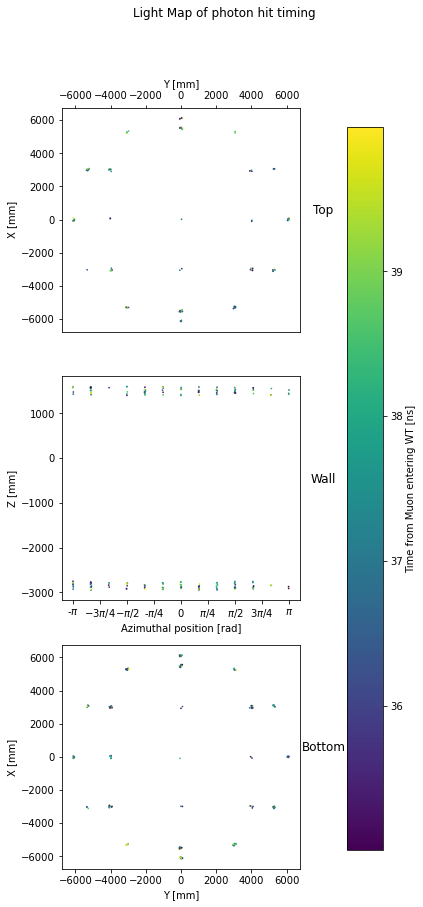

In [22]:
plotLightMapTime(top_hits, side_hits, bottom_hits, title="Light Map of photon hit timing", s=0.5)


In [24]:
PhotonFlags_flip = GetPhotonFlags(Data1['Flags'])
HitTimes_detect = PhotonTiming[PhotonFlags_flip['SURFACE_DETECT']]

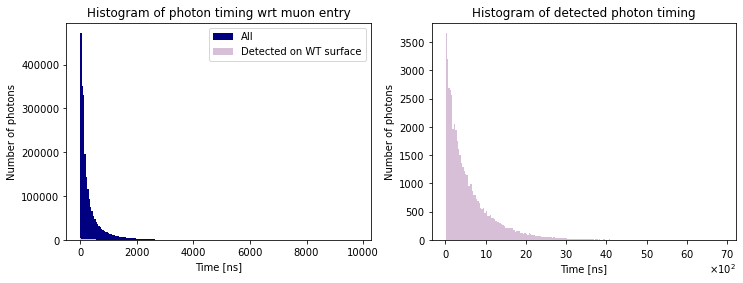

In [36]:
#all photon wavelengths
# HitTimes = Data1['ChannelTimes'] 
# HitTimes = Data1['PhotonTime'] 

#plot histograms of all wavelengths generated and of only the ones detected
f, axes = plt.subplots(1, 2, figsize=(12,4)) #sharey=True

# axes[0].set_title("Histogram of photon timing")
axes[0].set_title("Histogram of photon timing wrt muon entry")

axes[0].hist(PhotonTiming, bins=200, color="navy", label="All")
# axes[0].hist(HitTimes_detect, bins=200, color='thistle', label="Detected on given surface")
axes[0].hist(HitTimes_detect, bins=200, color='thistle', label="Detected on WT surface")

axes[0].set_xlabel("Time [ns]")
axes[0].set_ylabel("Number of photons")
axes[0].legend()

# axes[1].ticklabel_format(style='sci', axis='x', useMathText=True, scilimits=(2,2))
axes[1].set_title("Histogram of detected photon timing")
axes[1].hist(HitTimes_detect, bins=200, color='thistle')

axes[1].set_xlabel("Time [ns]")
axes[1].set_ylabel("Number of photons")
plt.show()

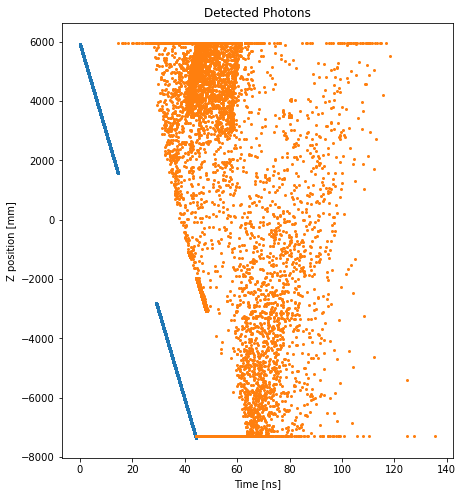

In [16]:
f, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,8))

#quick check of the calculated creatation time of each photon, to make sure they are actually linear
axs.scatter(timeFile, I_pos[2], s=4, label='intial')

axs.scatter(HitTimes_detect, detectedPos[:, 2], s=4, label='detected')
axs.set_xlabel("Time [ns]")
axs.set_ylabel("Z position [mm]")
axs.set_title("Detected Photons")
plt.show() 

## Looking at PMTs with Channel data

In [46]:
print(Data1.keys())

print(Data1['NumDetected'])
print(np.sum(Data1['NumDetected']))

dict_keys(['NumDetected', 'ChannelCharges', 'ChannelIDs', 'NumHitChannels', 'IncidentAngles', 'Flags', 'LastHitTriangle', 'FinalPosition', 'InitialPosition', 'DetectedPos', 'PhotonWavelength', 'DetectorHit'])
[ 1637 12173  6490  2326  7849  1356  2669  1739 10344  4744]
51327


In [47]:
#for each photon hit, records which PMT is hit
ChannelIDs = Data1['ChannelIDs']
print(len(ChannelIDs))

#total number of channels hit for each muon (so max here is the total number of PMTs used)
NumHitChannels = Data1['NumHitChannels']
print(np.sum(Data1['NumHitChannels']))
# ChannelIDs

698
698


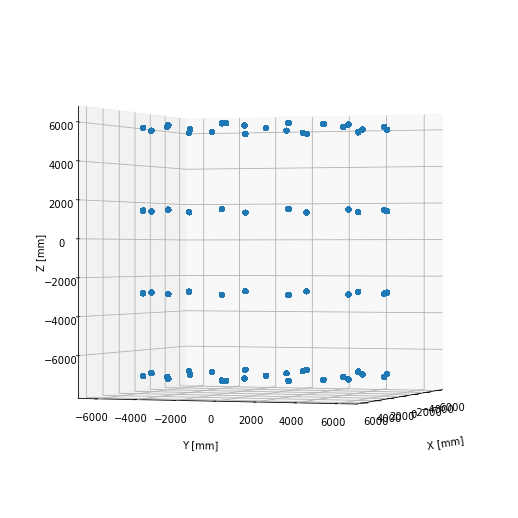

In [48]:
PMTHit_pos = Data1['DetectorHit'].T
fig = plt.figure(figsize=(7,7))
axes = mplot3d.Axes3D(fig)

axes.scatter3D(PMTHit_pos[0], PMTHit_pos[1], PMTHit_pos[2], 'blue')

axes.set_xlabel("X [mm]")
axes.set_ylabel("Y [mm]")
axes.set_zlabel("Z [mm]")
axes.xaxis.labelpad=20
axes.yaxis.labelpad=15
# axes.zaxis.labelpad=15

#change angle of view - (elevation, azimuth) angles in degrees
# ‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
axes.view_init(0, 20)

# 0, 90 - XZ plane; 90, 90 - top views

plt.show()

## Making a histogram of hits per PMT per muon event

In [99]:
Flags = Data1['Flags']
#get the detection flags as a boolean list
detectionflag = (Flags & (0x1 << 2)).astype(bool)

tempTime = Data1['PhotonTime'][detectionflag]
tempHitPos = Data1['DetectorHit'] #location of the nearest PMT of each photon hit
Time = []
HitPos = []
HitsperPMT = []

for i in Data1['NumDetected']:
    Time.append([tempTime[0:i]])
    #HitPo.append([tempHitPos[0:i]])
    
    #get all hit detector positions for a given event
    HitPos = tempHitPos[0:i]
    
    tempTime = tempTime[i:]
    tempHitPos = tempHitPos[i:]
    
    # Gets the position of each unique entry - so should have one position for each PMT hit
    uniquePMTs = np.unique(HitPos, axis=0)
    
    #now count how many times that PMT is hit
    NumHits = np.zeros(len(uniquePMTs))

    #loops through all the unique PMT positions
    for x, PMT in enumerate(uniquePMTs): 
        #gets the index of all the instances of that PMT position
        i = np.where((HitPos == (PMT[0], PMT[1], PMT[2])).all(axis=1)) 
        NumHits[x] = len(i[0]) 
        
    #save all the numbers of hits per PMT for this event
    HitsperPMT.append(NumHits)

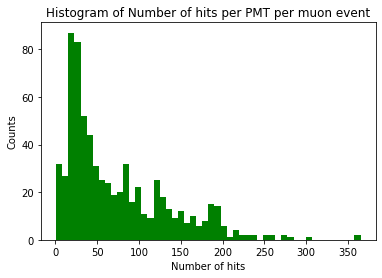

In [159]:
#flatten the array as we want to look at all events for the histogram
AllHitsperPMT = [item for sublist in HitsperPMT for item in sublist]

f, axe = plt.subplots(1, 1, figsize=(6,4))

axe.set_title("Histogram of Number of hits per PMT per muon event")
axe.hist(AllHitsperPMT, bins=50, color="green")
axe.set_ylabel("Counts")
axe.set_xlabel("Number of hits")
#axe.legend()

# Print("Number of hits per PMT, Mean", np.mean(numberPMT_hits), Verbose=v)
# Print("Std Dev", np.std(numberPMT_hits), Verbose=v)
plt.show()

In [269]:
NumHitsData = np.genfromtxt('numberofhitsperPMTpermuon.csv', delimiter = ',', skip_header=2).T

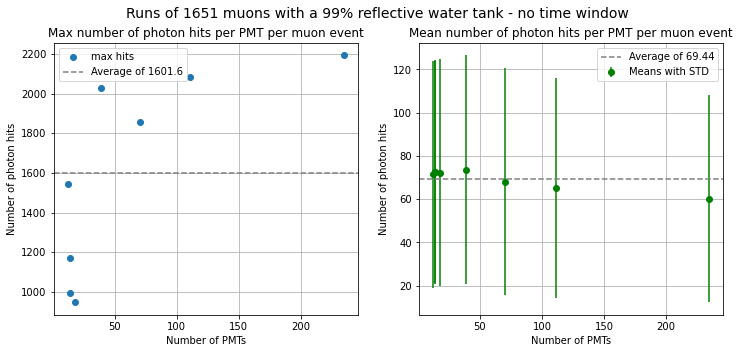

In [307]:
f, axe = plt.subplots(1, 2, figsize=(12,5))

f.suptitle("Runs of {} muons with a 99% reflective water tank - no time window".format(int(NumHitsData[1][1])), size=14)

axe[0].plot(NumHitsData[2], NumHitsData[6], ls='', marker="o", label="max hits")
axe[0].axhline(np.mean(NumHitsData[6]), color='grey', ls="--", label="Average of {:.5}".format(np.mean(NumHitsData[6])))
axe[0].set_title("Max number of photon hits per PMT per muon event")
axe[0].set_ylabel("Number of photon hits")
axe[0].set_xlabel("Number of PMTs")
axe[0].legend()
axe[0].grid()

axe[1].errorbar(NumHitsData[2], NumHitsData[3], yerr=NumHitsData[4], ls='', marker="o", label="Means with STD", c='g')
axe[1].axhline(np.mean(NumHitsData[3]), color='grey', ls="--", label="Average of {:.4}".format(np.mean(NumHitsData[3])))
axe[1].set_title("Mean number of photon hits per PMT per muon event")
axe[1].set_ylabel("Number of photon hits")
axe[1].set_xlabel("Number of PMTs")
axe[1].grid()
axe[1].legend()
plt.show()

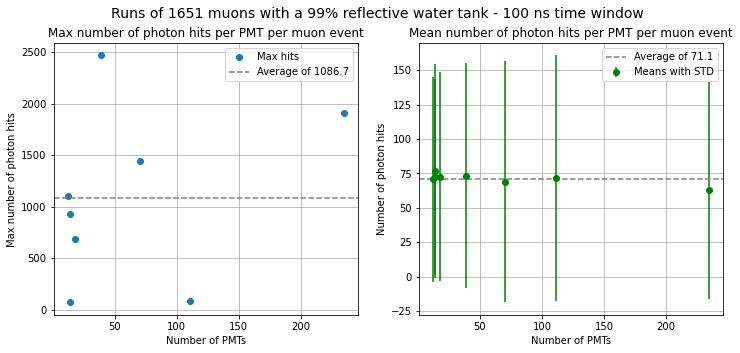

In [306]:
f, axe = plt.subplots(1, 2, figsize=(12,5))

f.suptitle("Runs of {} muons with a 99% reflective water tank - 100 ns time window".format(int(NumHitsData[1][1])), size=14)

axe[0].plot(NumHitsData[2], NumHitsData[10], ls='', marker="o", label="Max hits")
axe[0].axhline(np.mean(NumHitsData[10]), color='grey', ls="--", label="Average of {:.5}".format(np.mean(NumHitsData[10])))
axe[0].set_title("Max number of photon hits per PMT per muon event")
axe[0].set_ylabel("Max number of photon hits")
axe[0].set_xlabel("Number of PMTs")
axe[0].legend()
axe[0].grid()

axe[1].errorbar(NumHitsData[2], NumHitsData[7], yerr=NumHitsData[8], ls='', marker="o", label="Means with STD", c='g')
axe[1].axhline(np.mean(NumHitsData[7]), color='grey', ls="--", label="Average of {:.4}".format(np.mean(NumHitsData[7])))
axe[1].set_title("Mean number of photon hits per PMT per muon event")
axe[1].set_ylabel("Number of photon hits")
axe[1].set_xlabel("Number of PMTs")
axe[1].grid()
axe[1].legend()
plt.show()

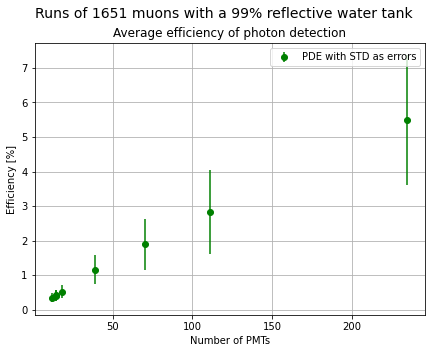

In [295]:
f, axe = plt.subplots(1, 1, figsize=(7,5))

f.suptitle("Runs of {} muons with a 99% reflective water tank".format(int(NumHitsData[1][1])), size=14)

# axe[0].plot(NumHitsData[2], NumHitsData[7], ls='', marker="o", label="max hits")
# axe[0].set_title("Max number of photon hits per PMT per muon event")
# axe[0].set_ylabel("Number of photon hits")
# axe[0].set_xlabel("Number of PMTs")
# axe[0].grid()

numMuons = NumHitsData[1]

axe.errorbar(NumHitsData[2], NumHitsData[11], yerr=NumHitsData[13], ls='', marker="o", label="PDE with STD as errors", c='g')
# axe.plot(50, 50*0.025, ls='', marker='s') #it's about 2.5% per 100 PMTs
axe.set_title("Average efficiency of photon detection")
axe.set_ylabel("Efficiency [%]")
axe.set_xlabel("Number of PMTs")
axe.legend()
axe.grid()
plt.show()

In [216]:
Muons1000 = np.genfromtxt('../Muons/MuonOutput1000.csv', delimiter = ',', skip_header=1).T

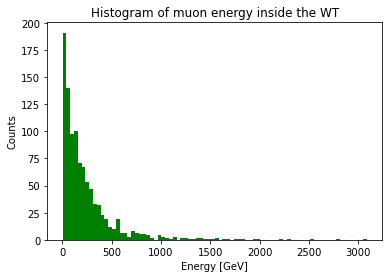

In [296]:
f, axe = plt.subplots(1, 1, figsize=(6,4))

axe.set_title("Histogram of muon energy inside the WT")
axe.hist(Muons1000[2], bins=80, color="green")
axe.set_ylabel("Counts")
axe.set_xlabel("Energy [GeV]")
plt.show()

In [226]:
maX = 10000e3
mean = 7.859e5

mean*0.01/125

62.872

In [245]:
print(total)

10000000.0


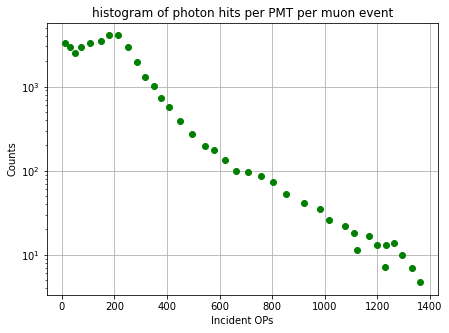

In [267]:
# RemNs = np.genfromtxt('200ns.csv', delimiter = ',').T
RemNs = np.genfromtxt('1ms.csv', delimiter = ',').T

f, axe = plt.subplots(1, 1, figsize=(7,5))

# f.suptitle("Runs of {} muons with a 99% reflective water tank".format(int(NumHitsData[1][1])), size=14)

# numMuons = NumHitsData[1]

axe.plot(RemNs[0], RemNs[1], ls='', marker="o", label="max hits", c='g')
axe.set_yscale('log')
axe.set_title("histogram of photon hits per PMT per muon event")
axe.set_ylabel("Counts")
axe.set_xlabel("Incident OPs")
axe.grid()
plt.show()

In [268]:
np.average(RemNs[1])

allRems = np.array([])
for i, c in enumerate(RemNs[1]):
#     print(int(c), np.ones(int(c))*RemNs[0][i] )
#     allRems = np.concatenate( allRems, np.ones(int(c))*RemNs[0][i] )
    allRems = np.append(allRems, np.ones(int(c))*RemNs[0][i] )
    
    
np.average(allRems.flatten())   

180.0822866663795